# Business Goals
A key activity of the banking sector is giving out loans. Every successful loan nets the bank a profit that corresponds to the interest it charged on the loan. On the other hand, when the loan is not successful, the bank loses a part or even the totality of the funds it had lent.

Therefore, the bank's business goal is, on the one hand, to understand how its client's characteristics affect the loans' success rate and, on the other, to be able to evaluate loan requests and decide if they should be approved or not, to make sure it lends to as many people who are able to pay them back (increasing revenue) and denies the loan to anyone who would not be paying it (decreasing costs).

# Data Mining Goals
We are using data mining to achieve the business goal previously enunciated. We identified the following goals to consider the technique's application to be a success:

## Descriptive Analysis
 * We are able to analyse the customer data across several axes, including balances, cards, transaction history, past loans, demographics, etc.
 * We are able to identify imbalances between the collected data (training set) and the real population (testing set) and understand if, and how, the data differs in cardinality and distribution.
 * We are able to identify problems with our data, including outliers and missing data, and correct them.
 * We are able to create knowledge that allows us to identify the trends and data features that are predictive of a loans viability.

## Prescriptive Analysis
 * We can build or train a computational model that can classify and predict whether a loan will be successful when it is presented with relevant data about the client.
 * The model has high precision - if a loan is predicted to be successful, it should have a high probability of being successful. (low rate of false positives).
 * The model has high recall - if a loan is successful, it should have a high probability of being predicted as successful. (low rate of false negatives).
 * The model is transparent - it should be possible to understand what factors lead a loan to be predicted as successful or otherwise, and what how confident is the model in that classification.

# Data Integration

We were given a dataset that consisted of a series of .csv files that represented, in the relational paradigm, information about the bank's clients and activities. The following relations are present:
 * Demographic indicators about the regions that the bank operates in;
 * Basic information about the bank's clients, in connection to one of the regions;
 * Basic information about the bank's accounts, in connection to one of the regions;
 * Information about cards issued by the bank;
 * Information (dispositions) that linked cards, the client to which the card was issued, and the account that is linked to the card;
 * Transaction histories, including balances after each transaction, for each account;
 * Information about past loans, including whether they were successful, and a set of unclassified loans whose success is to be predicted.

We normalized these .csv files using the `data_cleaner.py` script, and imported the files, using the `db_importer.py` script, to two SQLite 3 databases, namely `database_train.db` and `database_test.db`.

After all of this was done, we moved to integrate the different information sources and join them into a single tabular source of information. To do this, we used the SQL we have learned to join information across each relation, starting from the loans. Whenever we encountered cardinalities in that were not zero or one-to-one, we duplicated entries or aggregated them as we saw fit. At the moment, we are using the following query:

In [5]:
query = """
with districts_short as (
    select id, ratio_urban_inhabitants, avg_salary,
           coalesce(unemployment_96, unemployment_95) as unemployment,
           cast(coalesce(crimes_96, crimes_95) as real) / no_inhabitants as crimes from districts
), t as (
    select account_id, count(*) transaction_count, avg(amount) transaction_avg_amount, min(balance) transaction_min_balance,
           max(balance) transaction_max_balance, avg(balance) transaction_avg_balance
    from transactions
    group by account_id
)
select l.date loan_date, l.amount loan_amount, l.duration loan_duration , l.payments loan_payments,
       a.date account_creation, t.transaction_count, t.transaction_avg_amount, t.transaction_min_balance,
       t.transaction_max_balance, t.transaction_avg_balance,
       d.ratio_urban_inhabitants, d.avg_salary, d.unemployment, d.crimes,
       c2.birthday as client_birthday, l.status as loan_status
from loans l
    left join accounts a on l.account_id = a.id
    left join t on t.account_id = a.id
    left join districts_short d on a.district_id = d.id
left join dispositions d2 on a.id = d2.account_id
left join clients c2 on d2.client_id = c2.id
"""

You can see that we are collected a sizeable amount of features to start out, but we hoped to remove or combine features before we moved on to more involved methods of analysis. Let's now import the data into pandas dataframes.

In [6]:
import pandas as pd
import sqlite3

train_dataset, test_dataset = None, None

with sqlite3.connect("./database_train.db") as db:
    train_dataset = pd.read_sql_query(sql = query, con = db)

with sqlite3.connect("./database_test.db") as db:
    test_dataset = pd.read_sql_query(sql = query, con = db)

In [7]:
train_dataset["source"] = ["train" for _ in range(train_dataset.shape[0])]
test_dataset["source"] = ["test" for _ in range(test_dataset.shape[0])]

dataset = pd.concat([train_dataset, test_dataset])

[('loan_date',
  array([<AxesSubplot:title={'center':'test_loan_date'}>,
         <AxesSubplot:title={'center':'train_loan_date'}>], dtype=object)),
 ('loan_amount',
  array([<AxesSubplot:title={'center':'test_loan_amount'}>,
         <AxesSubplot:title={'center':'train_loan_amount'}>], dtype=object)),
 ('loan_duration',
  array([<AxesSubplot:title={'center':'test_loan_duration'}>,
         <AxesSubplot:title={'center':'train_loan_duration'}>], dtype=object)),
 ('loan_payments',
  array([<AxesSubplot:title={'center':'test_loan_payments'}>,
         <AxesSubplot:title={'center':'train_loan_payments'}>], dtype=object)),
 ('account_creation',
  array([<AxesSubplot:title={'center':'test_account_creation'}>,
         <AxesSubplot:title={'center':'train_account_creation'}>],
        dtype=object)),
 ('amount',
  array([<AxesSubplot:title={'center':'test_amount'}>,
         <AxesSubplot:title={'center':'train_amount'}>], dtype=object)),
 ('balance',
  array([<AxesSubplot:title={'center':'test

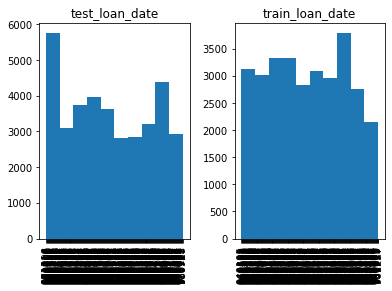

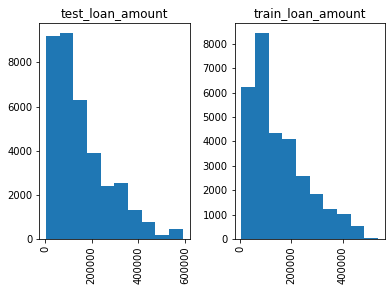

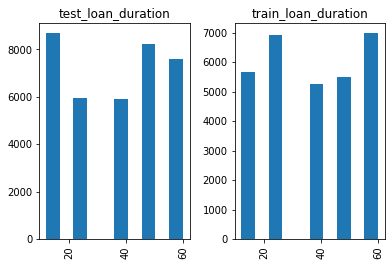

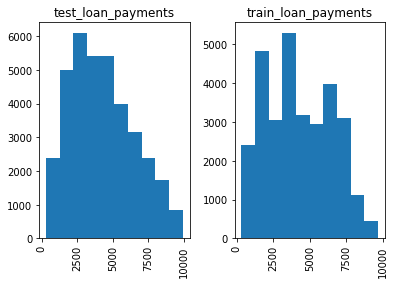

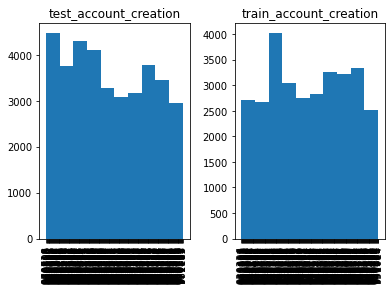

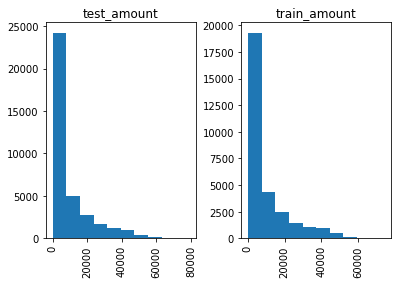

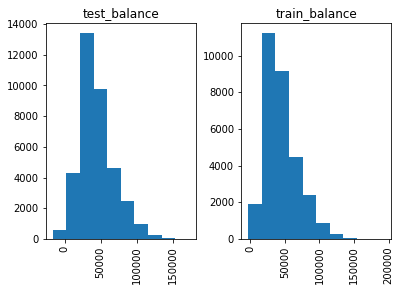

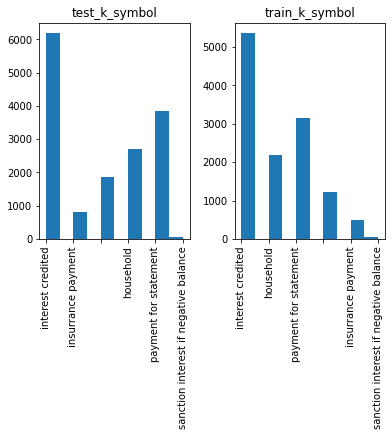

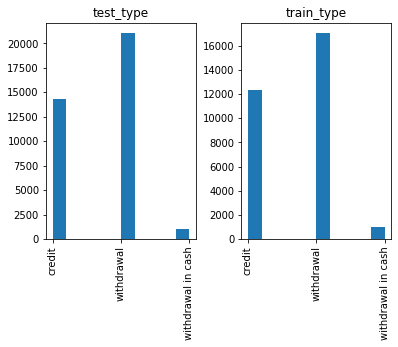

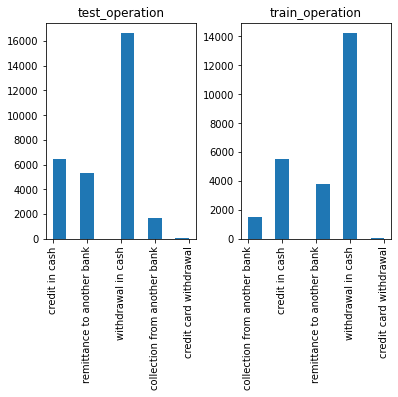

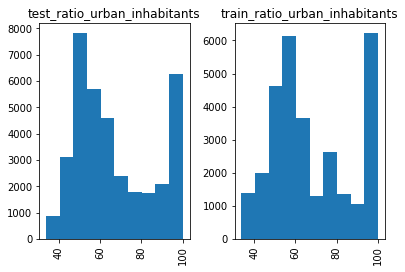

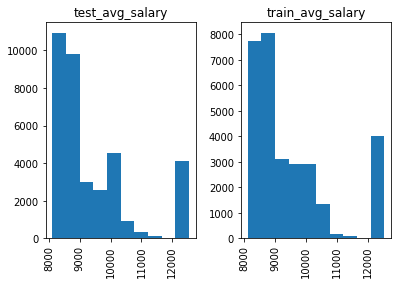

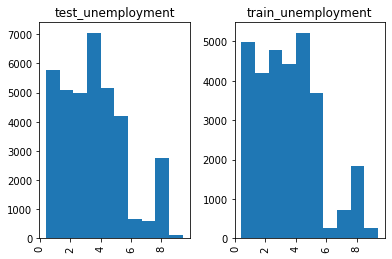

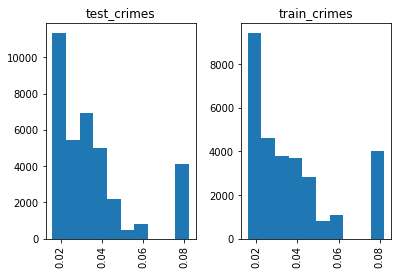

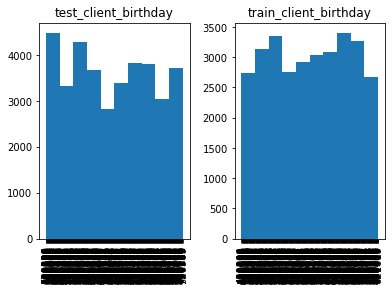

In [8]:
columns = [col for col in dataset.columns]
columns.remove("source")
columns.remove("loan_status")

partial_datasets = [(col, dataset[[col, "source", "loan_status"]]) for col in columns]
histograms = [(col, partial.hist(column=col, by="source")) for col, partial in partial_datasets]
for col, subs in histograms:
    for sub in subs:
        sub.set_title(f"{sub.get_title()}_{col}")
histograms

We did not detect any big discrepancies between the datasets, so we decided to move on to monovariate analysis.

# Missing Data

The feature set we initially selected does not seem to have missing data points.

# Monovariate Analysis

Here we are aiming to identify and possibly eliminate outliers, as well as try to understand if any variable has a direct correlation to the classification.

loan_amount                    AxesSubplot(0.125,0.71587;0.168478x0.16413)
loan_duration               AxesSubplot(0.327174,0.71587;0.168478x0.16413)
loan_payments               AxesSubplot(0.529348,0.71587;0.168478x0.16413)
transaction_count           AxesSubplot(0.731522,0.71587;0.168478x0.16413)
transaction_avg_amount        AxesSubplot(0.125,0.518913;0.168478x0.16413)
transaction_min_balance    AxesSubplot(0.327174,0.518913;0.168478x0.16413)
transaction_max_balance    AxesSubplot(0.529348,0.518913;0.168478x0.16413)
transaction_avg_balance    AxesSubplot(0.731522,0.518913;0.168478x0.16413)
ratio_urban_inhabitants       AxesSubplot(0.125,0.321957;0.168478x0.16413)
avg_salary                 AxesSubplot(0.327174,0.321957;0.168478x0.16413)
unemployment               AxesSubplot(0.529348,0.321957;0.168478x0.16413)
crimes                     AxesSubplot(0.731522,0.321957;0.168478x0.16413)
dtype: object

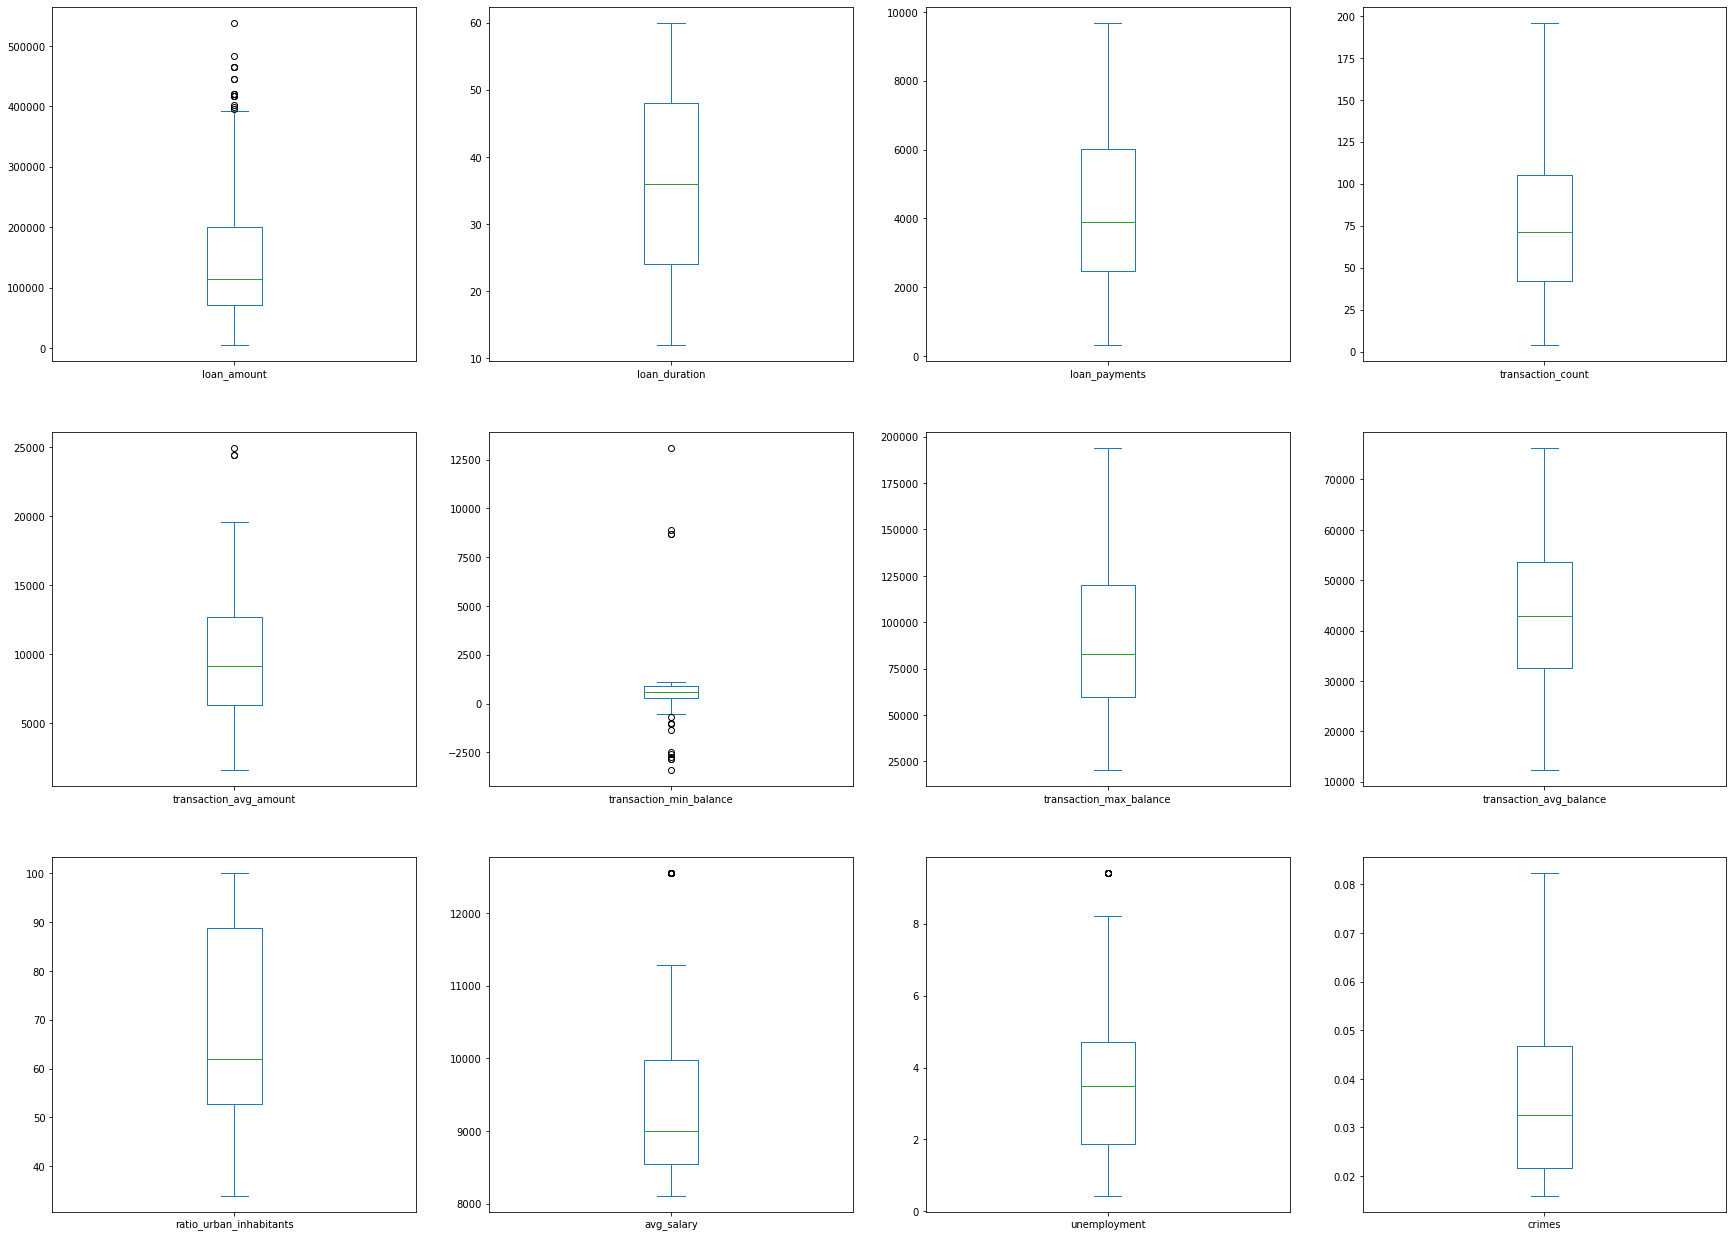

In [6]:
no_label = train_dataset.drop(columns=["source", "loan_status"])

no_label.plot(kind="box", subplots=True, layout=(4,4), figsize=(30, 30))

Analysing these graphs, we see that there are some features where outliers are present. In most cases, though, we could find reasonable explanations for why the outliers existed (for example, most people do not have access to very big lines of credit, but those that do take out very big loans that appear as outliers in loan_amount; some people go often into overdraft situations, so their min balance appears as outliers in the corresponding plot).

However, this analysis prompted us to investigate these very low (even negative) minimum balances:

<AxesSubplot:xlabel='transaction_min_balance', ylabel='loan_status'>

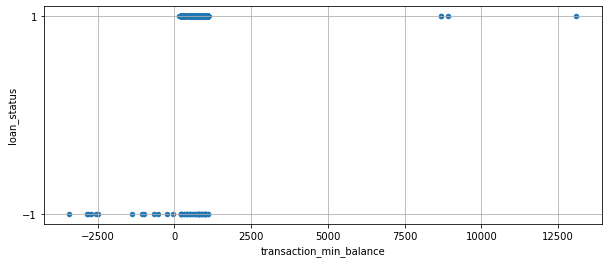

Bad pipe message: %s [b'\x99W\xf0\x82\x06\xb5\x7f\x9c\xe3\xd8)\xd3\x05BJ[\x83\xb2 F\xa6\x92\x13\x05{\x001\xe1\t\xb1\xa9\xa7\x94<o|\xee\xec\xa9\xfd\xe3vO\xd5\xb9b\xc2V=@P\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00', b'\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01']
Bad pipe message: %s [b'%{\xce\xa4\xb8\x8de\xbe\x07!MI~\xcb\xf0a"\xf4\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0\'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x9

In [14]:
train_dataset.plot(kind="scatter", x="transaction_min_balance", y="loan_status", yticks=[-1, 1], figsize = (10, 4), grid=True)

There's an interesting correlation! We can deprehend that in the case of negative minimum balances, the accounts that have them can be strongly predicted to result in loan failures.

But alas, this cannot surely be our only way of predicting, otherwise we would have very bad precision: there are many cases where the minimum balance is not under 0 but the loan is still unsuccessful.